In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2 as cv
import torchlayers as tl
import os

In [3]:
root = './data/kcar/'
paths = []
for company in os.listdir(root):
    company = os.path.join(root,company)
    for car in os.listdir(company):
        car = os.path.join(company, car)
        for year in os.listdir(car):
            paths.append(os.path.join(car, year))

In [19]:
import shutil

# os.mkdir(root+'lights')
# os.mkdir(root+'darks')

for path in paths:
    for time in os.listdir(path):
        time_folder = os.path.join(path,time)
        for subdir in os.listdir(time_folder):
            H_folder = os.path.join(time_folder,subdir)
            for file in os.listdir(H_folder):
                file_path = os.path.join(H_folder,file)
                lights_path = root+'lights/'+path.split('\\')[1]+'/'+path.split('\\')[2]
                darks_path = root+'darks/'+path.split('\\')[1]+'/'+path.split('\\')[2]
                if not os.path.isdir(lights_path):
                    if not os.path.isdir('./data/kcar/lights/'+path.split('\\')[1]):
                        os.mkdir('./data/kcar/lights/'+path.split('\\')[1])
                    os.mkdir(lights_path)
                if not os.path.isdir(darks_path):
                    if not os.path.isdir('./data/kcar/darks/'+path.split('\\')[1]):
                        os.mkdir('./data/kcar/darks/'+path.split('\\')[1])
                    os.mkdir(darks_path)
                    
                if time!='실내' and time!='실내(비)':
                    if int(time[:2])<18:
                        shutil.move(file_path,lights_path+'/'+file)
                    else:
                        shutil.move(file_path,darks_path+'/'+file)

Dataset ImageFolder
    Number of datapoints: 24954
    Root location: ./data/kcar_edge/lights
    StandardTransform
Transform: Compose(
               Resize(size=(120, 120), interpolation=bilinear)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 24954
    Root location: ./data/kcar/lights
    StandardTransform
Transform: Compose(
               Resize(size=(120, 120), interpolation=bilinear)
               ToTensor()
           )
52
G4 렉스턴


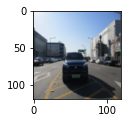

G4 렉스턴


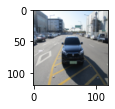

G4 렉스턴


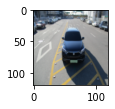

G4 렉스턴


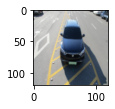

G4 렉스턴


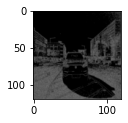

G4 렉스턴


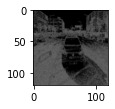

G4 렉스턴


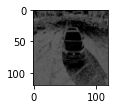

G4 렉스턴


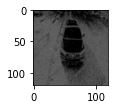

In [2]:
trans = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor()])

# datas = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
# train_size = int(len(datas) * 0.8)
# test_size = len(datas) - train_size
# train_sets, test_sets = torch.utils.data.random_split(datas, [train_size, test_size])

# edge_datas = torchvision.datasets.ImageFolder(root = './data/kcar_edge', transform = trans)
# edge_train_size = int(len(edge_datas) * 0.8)
# edge_test_size = len(edge_datas) - edge_train_size
# edge_train_sets, edge_test_sets = torch.utils.data.random_split(edge_datas, [edge_train_size, edge_test_size])

edge_train_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/lights', transform = trans)
edge_test_sets = torchvision.datasets.ImageFolder(root = './data/kcar_edge/darks', transform = trans)
train_sets = torchvision.datasets.ImageFolder(root = './data/kcar/lights', transform = trans)
test_sets = torchvision.datasets.ImageFolder(root = './data/kcar/darks', transform = trans)
labels = train_sets.classes
print(edge_train_sets)
print(train_sets)
# print(test_sets)
# print(edge_test_sets)
print(len(labels))
for i in range(4):
    img, label = train_sets[i]
    print(labels[label])
    plt.subplot(241 + i)
    plt.imshow(np.clip(img.permute(1,2,0),0,1))
    plt.tight_layout()
    plt.show()
    # save_image(img, str(i)+'_.jpg')

for i in range(4):
    img, label = edge_train_sets[i]
    print(labels[label])
    plt.subplot(241 + i)
    plt.imshow(np.clip(img.permute(1,2,0),0,1))
    # save_image(img, str(i)+'edge.jpg')
    plt.tight_layout()
    plt.show()

In [58]:
root = './data/kcar/darks'
edge_root = './data/kcar_edge/darks/'
count =0 
for company in os.listdir(root):
    company = os.path.join(root, company)
    for year in os.listdir(company):
        year = os.path.join(company, year)
        for file in os.listdir(year):
            file_path = os.path.join(year, file)
            edge_path = edge_root+file_path.split('\\')[1]+'/'+file_path.split('\\')[2]
            if os.path.isfile(edge_path+'/'+file):
                continue
            if not os.path.isdir(edge_path):
                if not os.path.isdir(edge_root + file_path.split('\\')[1]):
                    os.mkdir(edge_root + file_path.split('\\')[1])
                os.mkdir(edge_path)
            
            img_array = np.fromfile(file_path, np.uint8)
            im = cv.imdecode(img_array, cv.IMREAD_COLOR)
            result, encoded_img = cv.imencode(".jpg", cv.Canny(im, 30, 50))
            if result:
                count+=1
                if count % 500 == 0:
                    print(str(count)+"/8494")
                with open(edge_path+'/'+file, mode='w+b') as f:
                    encoded_img.tofile(f)
            # count += 1
            # if count > 5000:
            #     img_array = np.fromfile(file_path, np.uint8)
            #     im = cv.imdecode(img_array, cv.IMREAD_COLOR)

            #     im = cv.Canny(im,30,50)
            #     plt.imshow(im, cmap = 'gray')
            #     plt.show()
            #     print(file)
            

500/8494
1000/8494
1500/8494
2000/8494


In [11]:
class CNN(tl.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = tl.Conv2d(64, kernel_size=6)
        self.conv2 = tl.Conv2d(128, kernel_size=3)
        self.conv3 = tl.Conv2d(256, kernel_size=3, padding=1)
        self.fc1 = tl.Linear(120)
        self.fc2 = tl.Linear(60)
        self.fc3 = tl.Linear(10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, self.num_flat_features(x)) # [batch_size, 50, 4, 4]
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features


In [3]:
train_loader = DataLoader(train_sets, batch_size = 32, num_workers = 2)
edge_train_loader = DataLoader(edge_train_sets, batch_size = 32, num_workers = 2)
test_loader = DataLoader(test_sets, batch_size = 32)
edge_test_loader = DataLoader(edge_test_sets, batch_size = 32)

In [4]:
model1 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    tl.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.MaxPool(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    # tl.ReLU(),
    tl.GlobalMaxPool(),
    tl.Linear(52),  # Output for 52 classes
)
model1 = tl.build(model1, torch.randn(1, 3, 120, 120))
model1.cuda()
model2 = torch.nn.Sequential(
    tl.Conv(64),  # specify ONLY out_channels
    torch.nn.ReLU(),  # use torch.nn wherever you wish
    tl.BatchNorm(),  # BatchNormNd inferred from input
    tl.Conv(128),  # Default kernel_size equal to 3
    tl.ReLU(),
    tl.MaxPool(),
    tl.Conv(256, kernel_size=11),  # "same" padding as default
    # tl.ReLU(),
    tl.GlobalMaxPool(),
    tl.Linear(52),  # Output for 52 classes
)
model2 = tl.build(model2, torch.randn(1, 3, 28, 28))
model2.cuda()

# one_way_model = torch.nn.Sequential(
#     tl.Conv(64),  # specify ONLY out_channels
#     tl.ReLU(),  # use torch.nn wherever you wish
#     tl.BatchNorm(),  # BatchNormNd inferred from input
#     tl.Conv(128),  # Default kernel_size equal to 3
#     tl.ReLU(),
#     tl.Conv(256, kernel_size=11),  # "same" padding as default
#     tl.GlobalMaxPool(),  # Known from Keras
#     tl.Linear(52),  # Output for 2 classes
# )
# one_way_model = tl.build(one_way_model, torch.randn(1, 3, 28, 28))
# one_way_model.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (7): GlobalMaxPool()
  (8): Linear(in_features=256, out_features=52, bias=True)
)

In [4]:
vgg_model1 = torchvision.models.vgg16(pretrained=True)
# arbitrary
# last_module = nn.Linear(1000, 100, bias=True)
# vgg_model1.add_module('last_module', last_module)
# last_module.apply(user_defined_initialize_function)
vgg_model1.cuda()
vgg_model2 = torchvision.models.vgg16(pretrained=True)
# arbitrary
# last_module = nn.Linear(1000, 100, bias=True)
# vgg_model2.add_module('last_module', last_module)
vgg_model2.cuda()
# model = vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.fc = nn.Linear(104, 52)
        
    def forward(self, x1, x2):
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        x = torch.cat((x1, x2), dim=1)
        # print(x1.shape, x.shape, self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))
        # print(x.shape)
        # print(x)
        x = self.fc(x)
        # print(x.shape)
        # print(x)
        return x

    def num_flat_features(self, x):  
        size = x.size()[1:] 
        num_features = 1 
        for s in size: 
            num_features *= s 
        return num_features

model = MyEnsemble(model1, model2)
# model = tl.build(model, torch.randn(1, 3, 28, 28), torch.randn(1, 3, 28, 28))
model.cuda()

MyEnsemble(
  (modelA): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (7): GlobalMaxPool()
    (8): Linear(in_features=256, out_features=52, bias=True)
  )
  (modelB): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(11, 11), stride=(1, 1)

In [6]:
import torch.optim as optim
# model = CNN()
# cnn = tl.build(model.cuda(), torch.randn(1, 3, 32, 32))
criterion = torch.nn.CrossEntropyLoss()

# set optimizer. model.parameter를 넘겨준다.
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2,5,8], gamma=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.01)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')
print(torch.cuda.is_available())
torch.cuda.empty_cache()

cuda:0 is available
True


In [8]:
model.train()
print(len(train_loader))
for epoch in range(10):
    for index, ((data, target), (edge_data, edge_target)) in enumerate(zip(train_loader, edge_train_loader)):
        data, target = data.cuda(), target.cuda()
        edge_data, edge_target = edge_data.cuda(), edge_target.cuda()

        output = model(data, edge_data)
        optimizer.zero_grad()
        print(target)
        print(output)
        loss = criterion(output, target)
        print(loss.item())
        loss.backward()
        optimizer.step()

        if index % 10 == 0:
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
    
    scheduler.step()
    print("-----")


780
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([[-0.5433, -0.0521, -0.0758,  ...,  0.3902,  0.1449,  0.0596],
        [-0.5060, -0.0534, -0.0657,  ...,  0.3562,  0.1252,  0.1177],
        [-0.5061, -0.0258, -0.0713,  ...,  0.3714,  0.1134,  0.0781],
        ...,
        [-0.5180, -0.0087, -0.0637,  ...,  0.3787,  0.1179,  0.0775],
        [-0.5837, -0.0321, -0.0489,  ...,  0.3884,  0.0651,  0.1015],
        [-0.5077, -0.0467, -0.0840,  ...,  0.3881,  0.0855,  0.1143]],
       device='cuda:0', grad_fn=<AddmmBackward>)
4.540042400360107
loss of 0 epoch, 0 index : 4.540042400360107
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([[1670.9548,  -42.2002,  -48.6055,  ...,    6.4409,  124.7095,
          -82.6871],
        [1706.3293,  -44.5360,  -58.8287,  ...,   -2.2206,  119.9899,
          -83.3724],
        

KeyboardInterrupt: 

In [20]:
model.train()  # 학습
print(len(train_loader))
for epoch in range(10): 
    optimizer.zero_grad()  # 기울기 초기화
    for index, ((data, target), (edge_data, edge_target)) in enumerate(zip(train_loader, edge_train_loader)):
        data, target = data.cuda(), target.cuda()
        edge_data, edge_target = edge_data.cuda(), edge_target.cuda()

        output = model(data, edge_data)
        loss = criterion(output, target)
        # print(loss.item())
        loss.backward()  # 역전파
        optimizer.step()

        if index % 10 == 0:
            print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))
    scheduler.step()    
    print("scheduler-step")
    print("-----") 

780


In [13]:
model.eval()  # test
test_loss = 0
correct = 0
size = len(test_loader.dataset)
count = 0
with torch.no_grad():
  for ((data, target), (edge_data, edge_target)) in zip(test_loader, edge_test_loader):
    data, target = data.cuda(), target.cuda()
    edge_data, edge_target = edge_data.cuda(), edge_target.cuda()
    output = model(data, edge_data)
    test_loss += criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    if count % 10 == 0:
      print(str(count) + "/" + str(size))
      print(str(correct) + "/" + str(count))
    #   show_images(data.cpu())
    #   show_images(edge_data.cpu())
    #   save_images(data.cpu(), "./data/temp")
    #   save_images(edge_data.cpu(), "./data/temp")
    #   print(str(count) + "/" + str(size))
    #   break
    count += 1
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss/size, correct, size,
        100. * correct / size))

0/8493
0/0
10/8493
0/10
20/8493
0/20


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from torchvision.utils import save_image

def imshow(img):
    img = img /2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.show()

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def save_images(images, path, nmax=64):
    count = 0
    for img in images:
        # result, encoded_img = cv.imencode(".jpg", np.transpose(img, (1,2,0)))
        # if result:
        count+=1
        #     with open(path+'/'+count, mode='w+b') as f:
        #         encoded_img.tofile(f)
        save_image(img, str(count)+'.jpg')

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [61]:
#one_way_model
one_way_criterion = torch.nn.CrossEntropyLoss()
one_way_optimizer = optim.Adam(one_way_model.parameters(), lr=0.0001, betas=(0.5, 0.999))
one_way_model.train()  # 학습
for epoch in range(1):
  for index, (data, target) in enumerate(train_loader):
    final_out = []
    data, target = data.cuda(), target.cuda()
    one_way_optimizer.zero_grad()  # 기울기 초기화

    output = one_way_model(data)
    final_out.extend(output.tolist())
    final_out = np.array(final_out)
    
    loss = one_way_criterion(output, target)
    loss.backward()  # 역전파
    one_way_optimizer.step()

    if index % 10 == 0:
      print("loss of {} epoch, {} index : {}".format(epoch, index, loss.item()))

one_way_model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = one_way_model(data)
    test_loss += one_way_criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

loss of 0 epoch, 0 index : 0.0029294120613485575
loss of 0 epoch, 10 index : 0.00897157471626997
loss of 0 epoch, 20 index : 0.011190810240805149
loss of 0 epoch, 30 index : 0.04228249192237854
loss of 0 epoch, 40 index : 0.0031786018516868353
loss of 0 epoch, 50 index : 0.03200159966945648
loss of 0 epoch, 60 index : 0.004906153306365013
loss of 0 epoch, 70 index : 0.008287521079182625
loss of 0 epoch, 80 index : 0.04673587530851364
loss of 0 epoch, 90 index : 0.03924395143985748
loss of 0 epoch, 100 index : 0.0034775377716869116
loss of 0 epoch, 110 index : 0.01661776192486286
loss of 0 epoch, 120 index : 0.03610484302043915
loss of 0 epoch, 130 index : 0.018478896468877792
loss of 0 epoch, 140 index : 0.022824572399258614
loss of 0 epoch, 150 index : 0.028436051681637764
loss of 0 epoch, 160 index : 0.0022251156624406576
loss of 0 epoch, 170 index : 0.004415685310959816
loss of 0 epoch, 180 index : 0.0034332452341914177
loss of 0 epoch, 190 index : 0.0029694545082747936
loss of 0 ep

In [64]:
one_way_model.eval()  # test
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    output = one_way_model(data)
    test_loss += one_way_criterion(output, target).item() # sum up batch loss
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    print("pred : "+str(pred)+"view as : "+str(target.view_as(pred)))
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

pred : tensor([[44],
        [29],
        [42],
        [38],
        [ 1],
        [ 3],
        [27],
        [ 2],
        [50],
        [35],
        [43],
        [ 5],
        [18],
        [25],
        [ 2],
        [ 7],
        [26],
        [16],
        [41],
        [ 3],
        [33],
        [28],
        [16],
        [40],
        [27],
        [37],
        [31],
        [ 7],
        [ 5],
        [ 6],
        [ 3],
        [32]], device='cuda:0')view as : tensor([[44],
        [29],
        [42],
        [38],
        [ 1],
        [ 3],
        [27],
        [ 2],
        [50],
        [35],
        [43],
        [ 5],
        [18],
        [25],
        [ 2],
        [ 7],
        [26],
        [16],
        [41],
        [ 3],
        [33],
        [28],
        [16],
        [40],
        [27],
        [37],
        [31],
        [ 7],
        [ 5],
        [ 6],
        [ 3],
        [32]], device='cuda:0')
pred : tensor([[24],
        [25],
        [ 7],
   

KeyboardInterrupt: 